In [1]:
import scanpy as sc
import anndata as ad
import pandas as pd

In [3]:
import os
os.chdir("/dcs04/lieber/lcolladotor/spatialHPC_LIBD4035/spatial_hpc")
os.getcwd()

'/dcs04/lieber/lcolladotor/spatialHPC_LIBD4035/spatial_hpc'

In [49]:
adata = ad.read_h5ad("snRNAseq_hpc/python_analysis/processed-data/adata_raw.h5")
adata.obs['round'] = ["R" + x for x in map(str, adata.obs['round'].map(int))]

# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

In [50]:
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True)

**First pass QC identifies sequencing round 3 as having higher % chrM and ribo transcripts.**

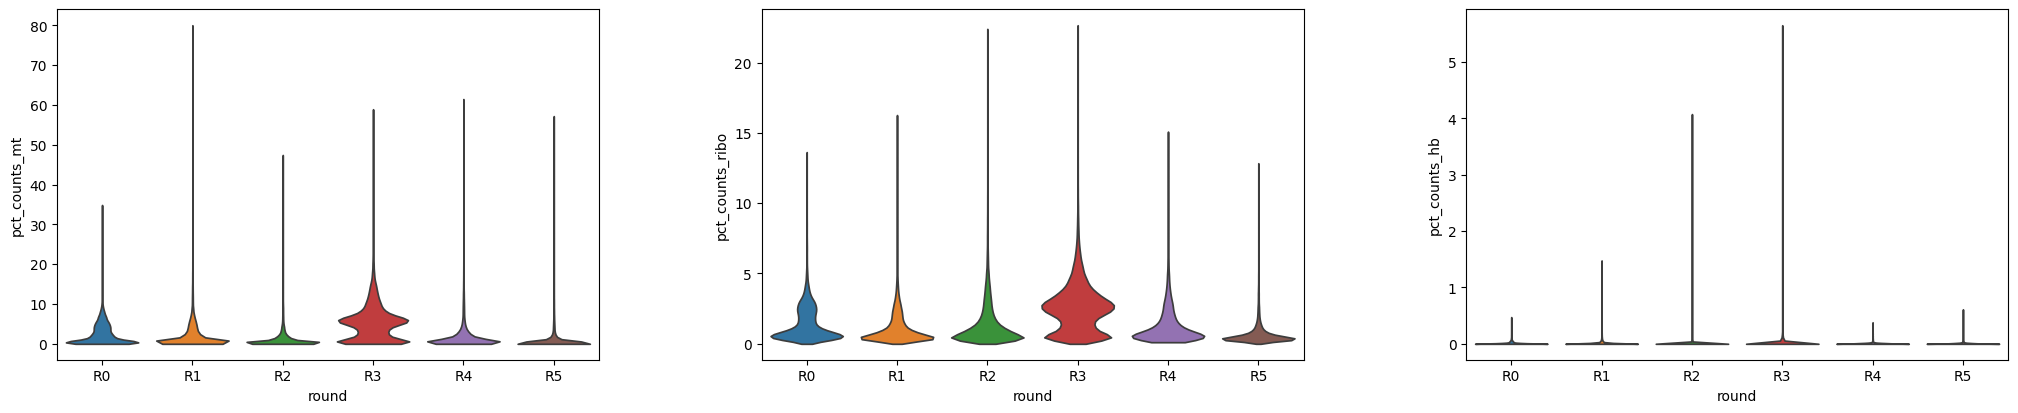

In [64]:
sc.pl.violin(adata, ["pct_counts_mt","pct_counts_ribo","pct_counts_hb"], groupby='round', size=0, multi_panel=True)

In [53]:
adata.obs['rnd_br_sort'] = [x+" "+y+" "+z for x, y, z in 
                            zip(adata.obs['round'].values, adata.obs['brnum'].values, adata.obs['sorted'].values)]

The brains that are present in seq round 3 are the only ones that are repeated in a different round.<br>
Looking just at those brains we can see that the non-R3 samples are distinct from the R3 samples, supporting the exclusion of R3.

In [54]:
adata.obs.groupby(['brnum','round'], observed=True).size()

brnum   round
Br2720  R3        7220
        R5       10094
Br2743  R1        8313
Br3942  R1        9312
Br6423  R3       12909
        R5       11647
Br6432  R2       12891
Br6471  R2       21245
Br6522  R3       12709
        R4       10645
Br8325  R0        9731
Br8492  R2       13159
Br8667  R1       11378
dtype: int64

In [55]:
adata_sub = adata[adata.obs['brnum'].isin(['Br2720','Br6423','Br6522'])]

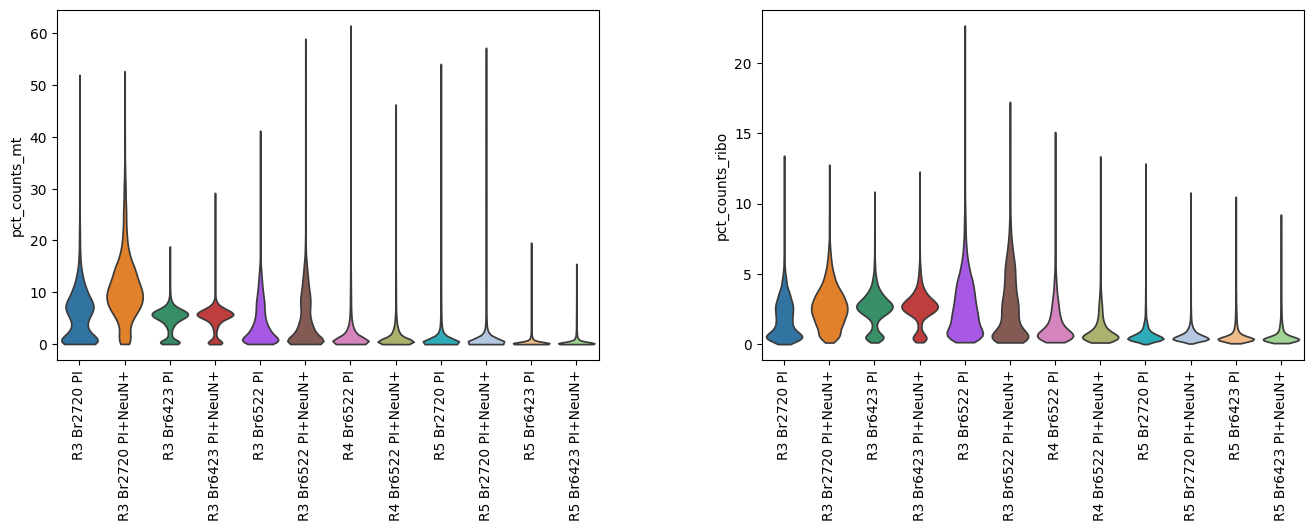

In [57]:
sc.pl.violin(adata_sub, ["pct_counts_mt","pct_counts_ribo"], groupby='rnd_br_sort', rotation=90,
            size=0) #size = size of points, default is 1

In [58]:
adata_filt = adata[adata.obs['round']!='R3'] #118415
adata_filt

View of AnnData object with n_obs × n_vars = 118415 × 36601
    obs: 'barcode', 'key', 'sample', 'tissue', 'brnum', 'round', 'sorted', 'id', 'dx', 'race', 'sex', 'age', 'pmi', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'rnd_br_sort'
    var: 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_version', 'gene_type', 'hgnc_id', 'tag', 'havana_gene', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'round_colors'

**After removing round 3, the sequencing rounds look much more consistent and a % chrM filter <20% is applied.**

/users/jthompso/.conda/envs/snPy/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


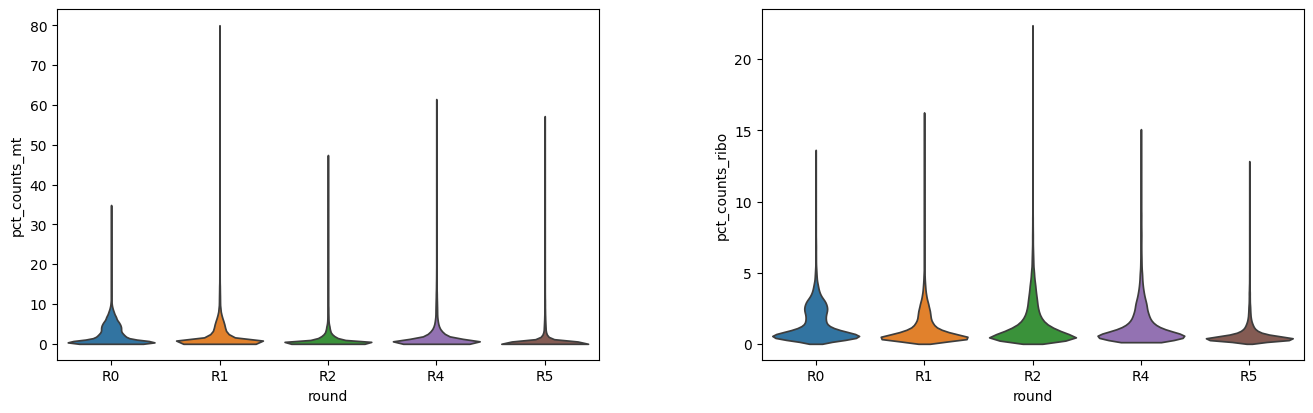

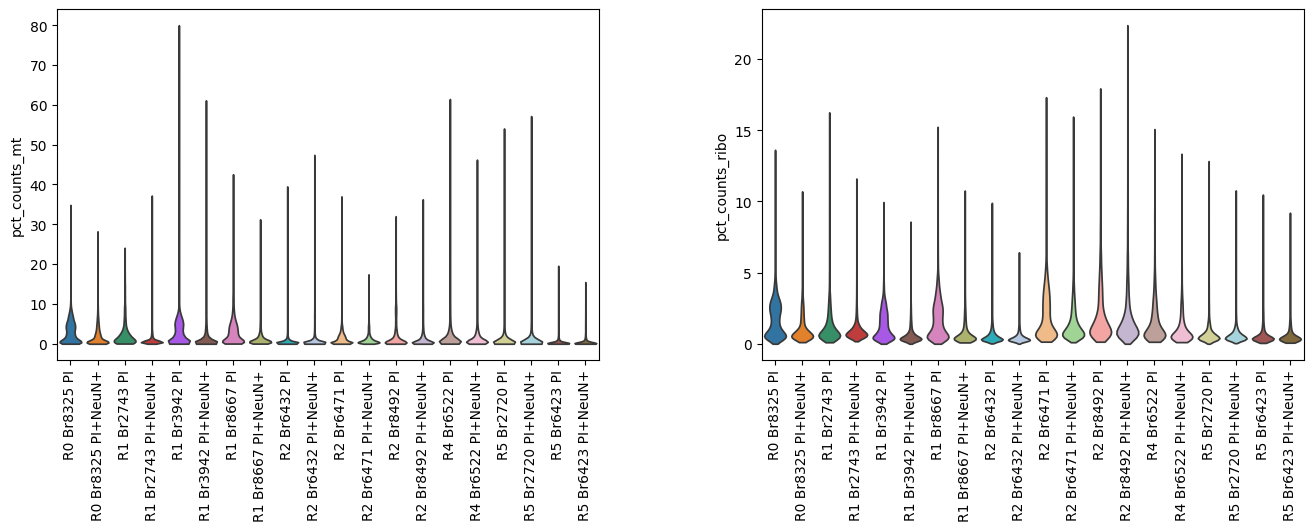

In [59]:
sc.pl.violin(adata_filt, ["pct_counts_mt","pct_counts_ribo"], groupby='round', size=0)
sc.pl.violin(adata_filt, ["pct_counts_mt","pct_counts_ribo"], groupby='rnd_br_sort', size=0, rotation=90)

In [60]:
adata_filt = adata_filt[adata_filt.obs['pct_counts_mt']<20] #118162
adata_filt

View of AnnData object with n_obs × n_vars = 118162 × 36601
    obs: 'barcode', 'key', 'sample', 'tissue', 'brnum', 'round', 'sorted', 'id', 'dx', 'race', 'sex', 'age', 'pmi', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'rnd_br_sort'
    var: 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_version', 'gene_type', 'hgnc_id', 'tag', 'havana_gene', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'round_colors', 'rnd_br_sort_colors'

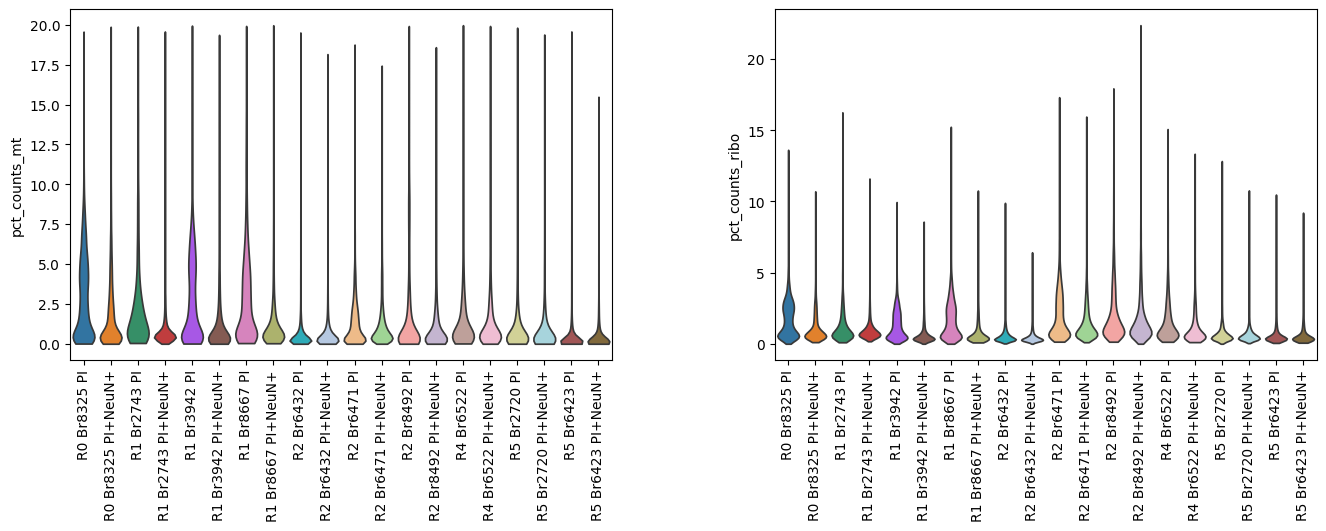

In [61]:
sc.pl.violin(adata_filt, ["pct_counts_mt","pct_counts_ribo"], groupby='rnd_br_sort', size=0, rotation=90)

/users/jthompso/.conda/envs/snPy/lib/python3.10/site-packages/scanpy/plotting/_utils.py:471: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


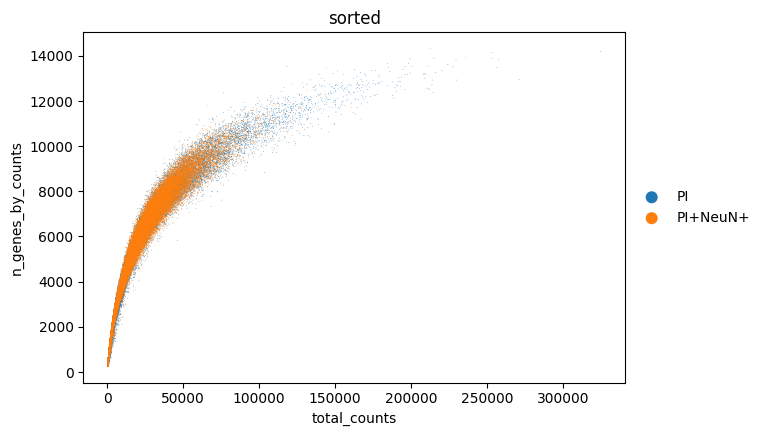

In [68]:
sc.pl.scatter(adata_filt, "total_counts", "n_genes_by_counts", color="sorted")

**This simple filter provides relatively high quality data that is an option of a loose threshold moving forward.**

In [63]:
adata_filt.obs.to_csv("snRNAseq_hpc/python_analysis/processed-data/filtered-matrix_obs_postqc-loose.csv")

**Another option is to further filter out nuclei based on QC metrics, and the differences between the PI sorted and the PI/NeuN sorted nuclei may be relevant.**

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt

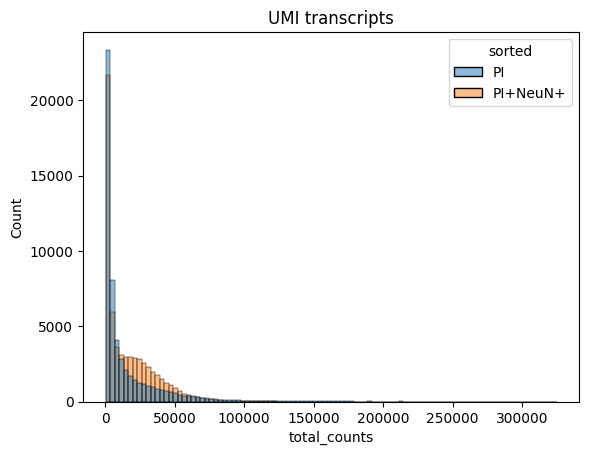

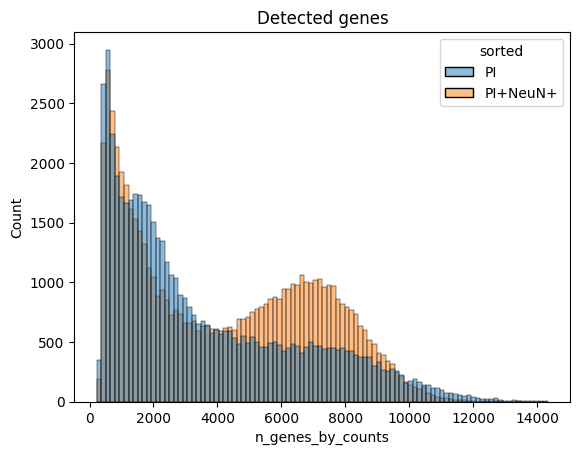

In [118]:
p1 = sns.histplot(adata_filt.obs, x="total_counts", hue="sorted", bins=100, kde=False)
plt.title("UMI transcripts")
plt.show()
p2 = sns.histplot(adata_filt.obs, x="n_genes_by_counts", hue="sorted", bins=100, kde=False)
plt.title("Detected genes")
plt.show()

In [66]:
adata_pi = adata_filt[adata_filt.obs['sorted']=="PI"]
adata_pinn = adata_filt[adata_filt.obs['sorted']=="PI+NeuN+"]

**\# detected genes**<br>
PI sorted nuclei exhibit a clear shelf around 1000 genes that when we zoom into the low end of the spectrum is consistent across all sequencing rounds

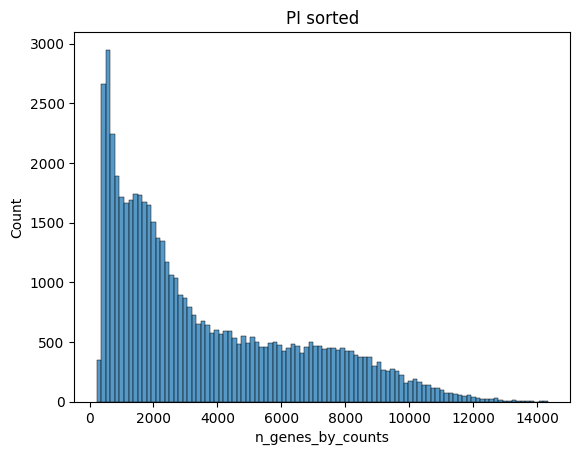

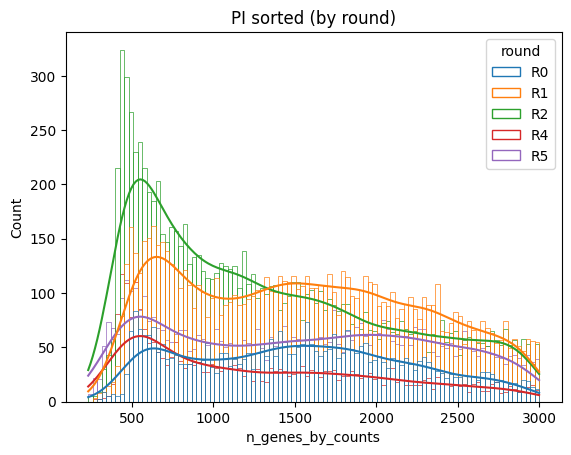

In [103]:
p1 = sns.histplot(adata_pi.obs["n_genes_by_counts"], bins=100, kde=False)
plt.title("PI sorted")
plt.show()
p1z = sns.histplot(adata_pi[adata_pi.obs["n_genes_by_counts"]<3000].obs, 
                   x="n_genes_by_counts", hue="round", 
                   bins=100, kde=True, fill=False)
plt.title("PI sorted (zoom, by round)")
plt.show()

Comparing thresholds of >1000 detected genes or >750 detected genes shows that using the lower threshold selectively removes more nuclei for 1 sample (16c-scp) which exhibits a shifted distribution from the other samples.

In [104]:
checkmin = adata_pi.obs['n_genes_by_counts']<1000
adata_pi.obs[checkmin].groupby('sample', observed=True).size()

sample
1c-scp      981
10c-scp    1083
12c-scp     885
14c-scp     646
16c-scp    1900
18c-scp     850
20c-scp    1414
32c-scp    1254
36c-scp     981
38c-scp     805
dtype: int64

In [105]:
checkmin = adata_pi.obs['n_genes_by_counts']<750
adata_pi.obs[checkmin].groupby('sample', observed=True).size()

sample
1c-scp      635
10c-scp     780
12c-scp     604
14c-scp     305
16c-scp    1408
18c-scp     604
20c-scp     924
32c-scp     931
36c-scp     737
38c-scp     538
dtype: int64

<Axes: xlabel='n_genes_by_counts', ylabel='Count'>

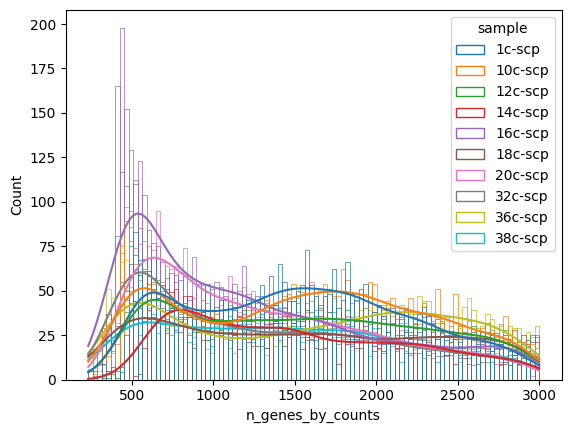

In [106]:
sns.histplot(adata_pi[adata_pi.obs["n_genes_by_counts"]<3000].obs, 
                   x="n_genes_by_counts", hue="sample", 
                   bins=100, kde=True, fill=False)

**Because of this selectivity, we filtered out PI nuclei with <=750 detected genes.**

For PI/NeuN sorted nuclei, round 2 exhibits a distinct distribution in the # detected genes compared to the other sequencing rounds.

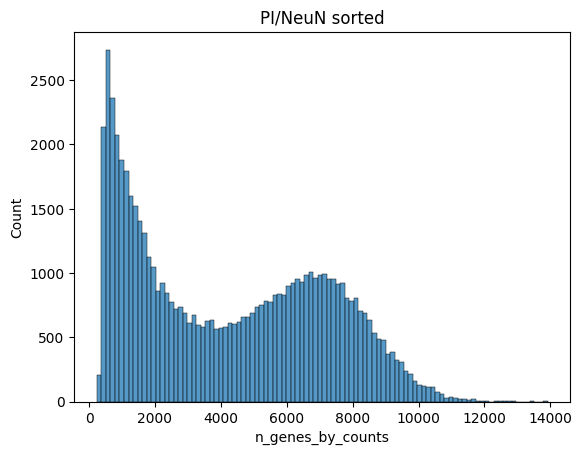

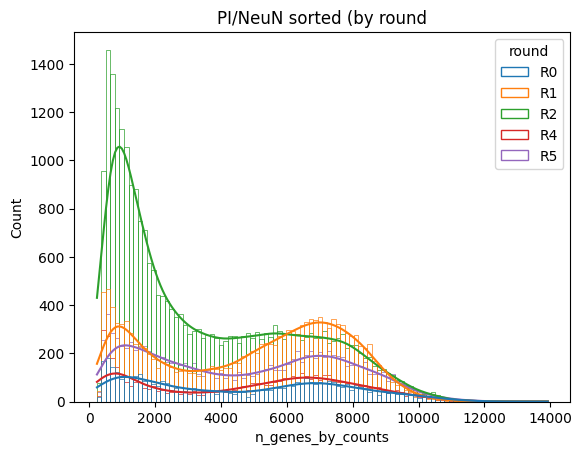

In [96]:
p2 = sns.histplot(adata_pinn.obs["n_genes_by_counts"], bins=100, kde=False)
plt.title("PI/NeuN sorted")
plt.show()
p2z = sns.histplot(adata_pinn.obs, x="n_genes_by_counts", hue="round", 
                   bins=100, kde=True, fill=False)
plt.title("PI/NeuN sorted (by round")
plt.show()

This is clearly attributable to sample 17c-scp and that when this sample is removed, the distributions of # detected genes are consistent across sequencing rounds.

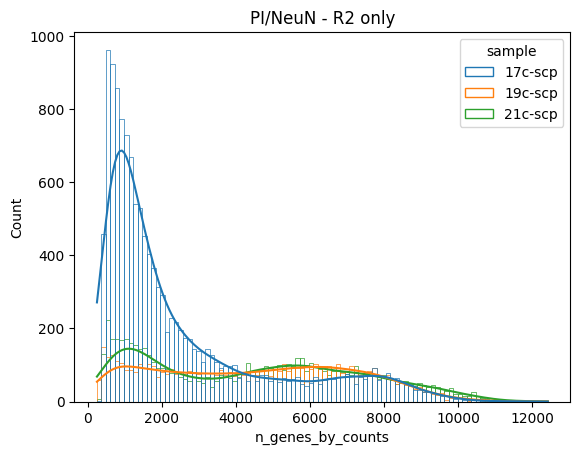

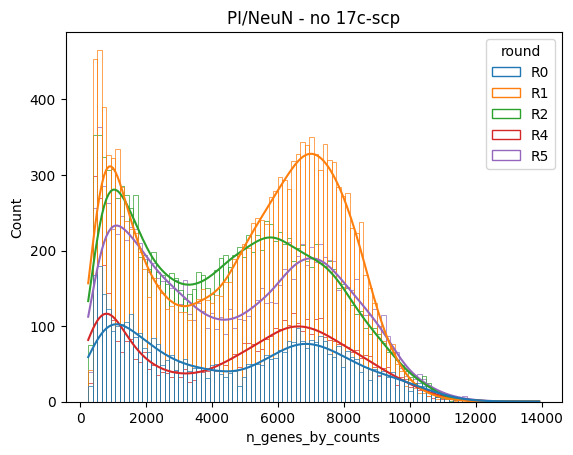

In [101]:
p1 = sns.histplot(adata_pinn[adata_pinn.obs['round']=="R2"].obs, x="n_genes_by_counts", 
             hue="sample", bins=100, kde=True, fill=False)
plt.title("PI/NeuN - R2 only")
plt.show()
p2 = sns.histplot(adata_pinn[adata_pinn.obs['sample']!="17c-scp"].obs, x="n_genes_by_counts", 
             hue="round", bins=100, kde=True, fill=False)
plt.title("PI/NeuN - no 17c-scp")
plt.show()

We chose to determine the lower limit of detected genes for the PI/NeuN nuclei without sample 17.<br>
**Although there is not a clear delineation, we decided to filter out Pi/NeuN nuclei with <=1000 detected genes.**

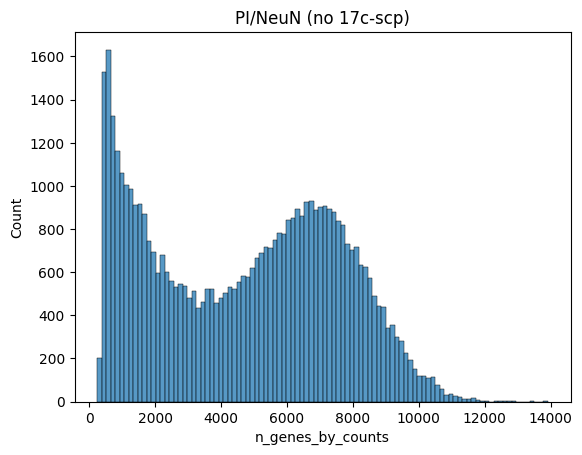

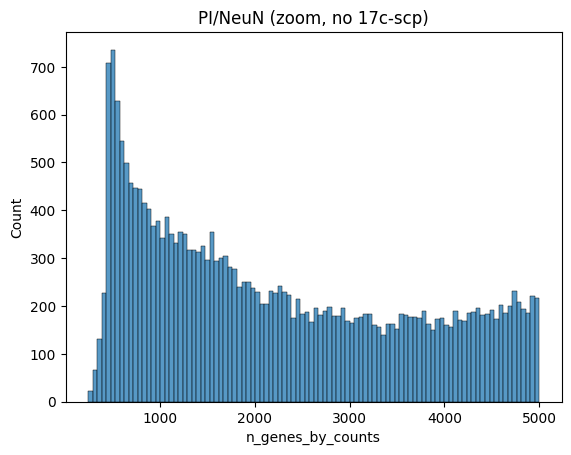

In [114]:
tmp = adata_pinn[adata_pinn.obs['sample']!="17c-scp"]
p3 = sns.histplot(tmp.obs,#tmp[tmp.obs['n_genes_by_counts']<5000].obs, 
                  x="n_genes_by_counts", #hue="round", 
                  bins=100, kde=False)
plt.title("PI/NeuN (no 17c-scp)")
plt.show()
p3z = sns.histplot(tmp.obs[tmp.obs['n_genes_by_counts']<5000], 
                  x="n_genes_by_counts", #hue="round", 
                  bins=100, kde=False)
plt.title("PI/NeuN (zoom, no 17c-scp)")
plt.show()

In [116]:
checkmin = adata_pinn.obs['n_genes_by_counts']<1000
adata_pinn.obs[checkmin].groupby('sample', observed=True).size()

sample
2c-scp      682
11c-scp     698
13c-scp     565
15c-scp     598
17c-scp    4113
19c-scp     694
21c-scp     893
33c-scp     986
37c-scp     785
39c-scp     549
dtype: int64

(above) This threshold selectively removed nuclei from sample 17c-scp which was encouraging.<br>
**After filtering based on the number of detected genes, we examined placing a lower limit on the number of UMI transcripts.**

In [117]:
adata_pi_filt = adata_pi[adata_pi.obs['n_genes_by_counts']>750]
adata_pinn_filt = adata_pinn[adata_pinn.obs['n_genes_by_counts']>1000]

Starting with PI nuclei, data from all sequencing rounds indicated that there is an increased number of nuclei with <2000 transcripts.<br>
**A filter of >2000 transcripts removes a similar number of nuclei across all samples, although it is higher in sample 16c-scp (consistent with previous data).**

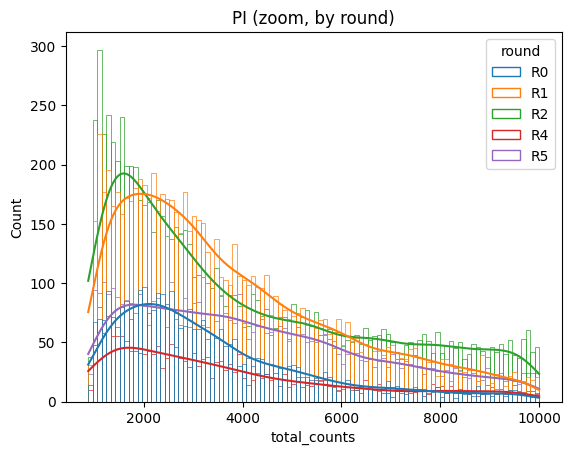

In [120]:
p1 = sns.histplot(adata_pi_filt[adata_pi_filt.obs['total_counts']<10000].obs, x="total_counts", hue="round", 
                  bins=100, kde=True, fill=False)
plt.title("PI (zoom, by round)")
plt.show()

In [121]:
checkmin = adata_pi_filt.obs['total_counts']<2000
adata_pi_filt.obs[checkmin].groupby('sample', observed=True).size()

sample
1c-scp      882
10c-scp     715
12c-scp     678
14c-scp     659
16c-scp    1062
18c-scp     483
20c-scp     974
32c-scp     624
36c-scp     468
38c-scp     559
dtype: int64

For the PI/NeuN nuclei we again see that sample 17c-scp is skewing round 2, so this sample was again removed to determine the threshold.

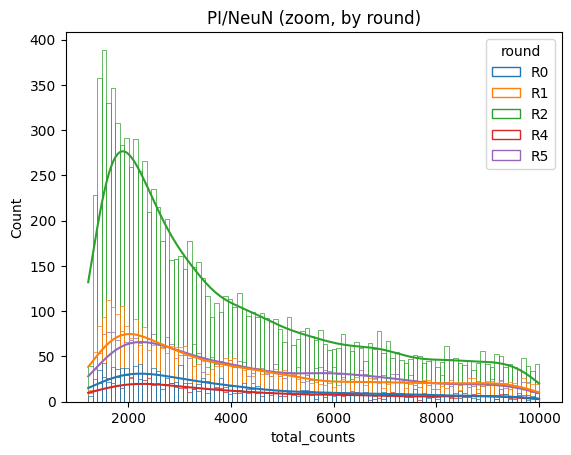

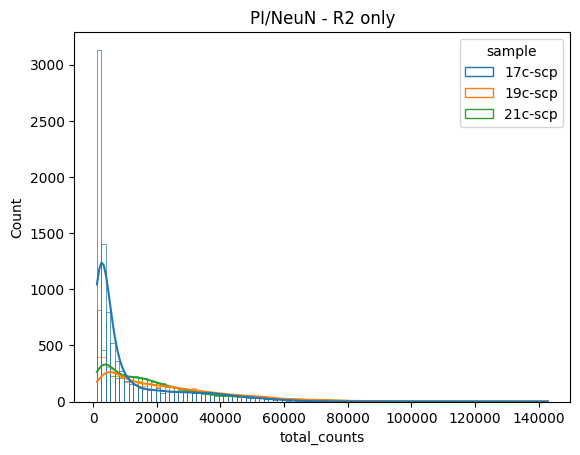

In [123]:
p2 = sns.histplot(adata_pinn_filt[adata_pinn_filt.obs['total_counts']<10000].obs, x="total_counts", hue="round", 
                  bins=100, kde=True, fill=False)
plt.title("PI/NeuN (zoom, by round)")
plt.show()
p3 = sns.histplot(adata_pinn_filt[adata_pinn_filt.obs['round']=="R2"].obs, x="total_counts", 
             hue="sample", bins=100, kde=True, fill=False)
plt.title("PI/NeuN - R2 only")
plt.show()

Excluding sample 17 indicated a small shelf around 3500 counts.

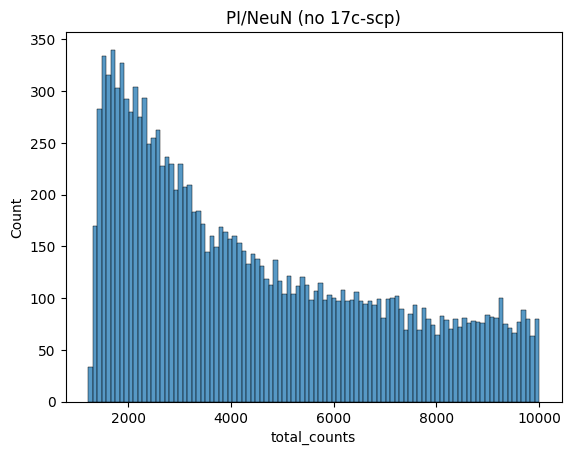

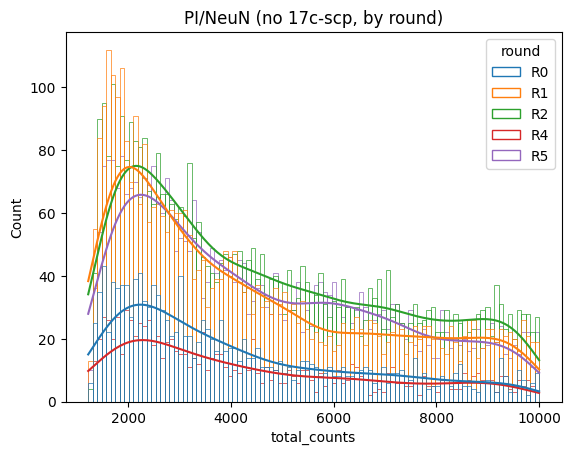

In [126]:
tmp = adata_pinn_filt[adata_pinn_filt.obs['sample']!="17c-scp"]
p4 = sns.histplot(tmp[tmp.obs['total_counts']<10000].obs, 
                  x="total_counts", #hue="round", 
                  bins=100, kde=False)
plt.title("PI/NeuN (no 17c-scp)")
plt.show()
p5 = sns.histplot(tmp[tmp.obs['total_counts']<10000].obs, 
                  x="total_counts", hue="round", 
                  bins=100, kde=True, fill=False)
plt.title("PI/NeuN (no 17c-scp, by round)")
plt.show()

In [127]:
checkmin = adata_pinn_filt.obs['total_counts']<3500
adata_pinn_filt.obs[checkmin].groupby('sample', observed=True).size()

sample
2c-scp      757
11c-scp     479
13c-scp     658
15c-scp     633
17c-scp    4116
19c-scp     665
21c-scp    1137
33c-scp     496
37c-scp     990
39c-scp     578
dtype: int64

**Filtering out PI/NeuN nuclei with <3500 total transcripts again selectively affected sample 17c-scp (4x as many nuclei removed as any other sample).**

In [128]:
adata_pi_filt = adata_pi_filt[adata_pi_filt.obs['total_counts']>2000]
adata_pinn_filt = adata_pinn_filt[adata_pinn_filt.obs['total_counts']>3500]

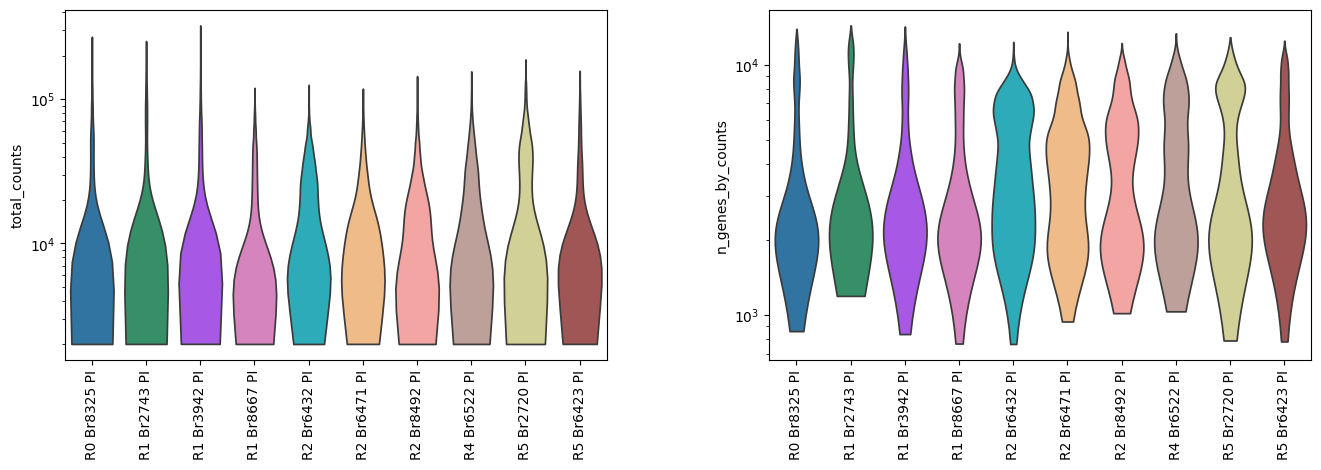

In [136]:
#PI nuclei
sc.pl.violin(adata_pi_filt, ["total_counts","n_genes_by_counts"], log=True, groupby='rnd_br_sort', rotation=90,
            size=0) #size = size of points, default is 1

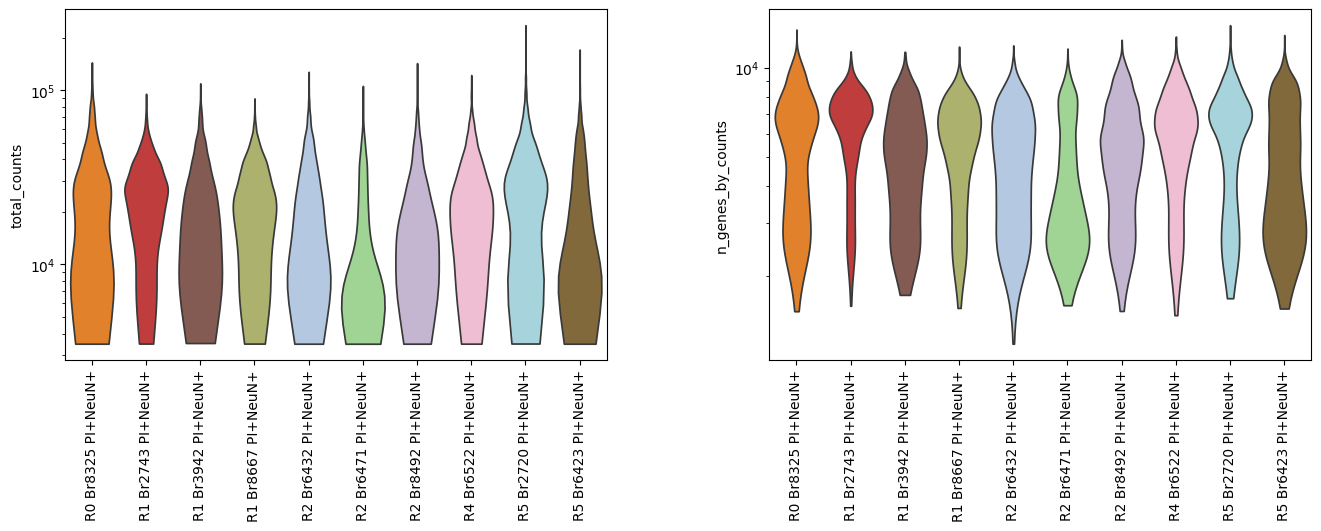

In [137]:
#PI/NeuN nuclei
sc.pl.violin(adata_pinn_filt, ["total_counts","n_genes_by_counts"], log=True, groupby='rnd_br_sort', rotation=90,
            size=0) #size = size of points, default is 1

In [129]:
adata_filt2 = ad.concat([adata_pi_filt, adata_pinn_filt])

In [132]:
adata_filt2.obs.to_csv("snRNAseq_hpc/python_analysis/processed-data/filtered-matrix_obs_postqc-strict.csv")

In [138]:
adata_filt2.write_h5ad("snRNAseq_hpc/python_analysis/processed-data/adata_qc-strict.h5")